In [32]:
# Upload the kaggle.json file
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"gongglerao","key":"4c7adbb2c405a0c2a42421414c29094a"}'}

In [33]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
# we need to set permissions 
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [34]:
#download the dataset from kaggle
!kaggle datasets download -d snap/amazon-fine-food-reviews

amazon-fine-food-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [35]:
#unzip the files 
from zipfile import ZipFile
file_name= 'amazon-fine-food-reviews.zip'
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [36]:
#@title Import necessary libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from bs4 import BeautifulSoup
from textblob import TextBlob

from tqdm import tqdm

from os import path

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [37]:
#@title Import data set
sqlconn = sqlite3.connect('database.sqlite')
dataset= pd.read_sql_query('SELECT * FROM Reviews WHERE Score != 3 LIMIT 20000',sqlconn)
def partition(x): # if rating is gater than 3 is positive, else negative
    if x<3:
        return 0
    return 1
dataset['Score'] = dataset.Score.map(partition)
dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [38]:
# finding all the duplicate rows
dataset[dataset.duplicated()]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


In [39]:
# Removing duplication 
df= dataset.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep= False,inplace=False)
print(df.shape)

(18733, 10)


In [40]:
# possability the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible. 
df[df.HelpfulnessNumerator > df.HelpfulnessDenominator]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


In [41]:
df=df[df.HelpfulnessNumerator<=df.HelpfulnessDenominator]

df=df.sort_index()
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


- **Text Preprocessing**

In [0]:
#  finding English contractions in text and removing 
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280

# <br /><br /> ==> after the above steps, we are getting "br br" , we are including them into stop words list 
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]) 

In [44]:
df = pd.DataFrame(df[['UserId','Score','Time','Text']])
df.head()

,UserId,Score,Time,Text
0,A3SGXH7AUHU8GW,1,1303862400,I have bought several of the Vitality canned d...
1,A1D87F6ZCVE5NK,0,1346976000,Product arrived labeled as Jumbo Salted Peanut...
2,ABXLMWJIXXAIN,1,1219017600,This is a confection that has been around a fe...
3,A395BORC6FGVXV,0,1307923200,If you are looking for the secret ingredient i...
4,A1UQRSCLF8GW1T,1,1350777600,Great taffy at a great price. There was a wid...


In [45]:
# Tokenization is the task of chopping it up into pieces


def clean_text(text):
    text = re.sub(r'[0-9]', '', text)
    text=  decontracted(text)
    text = re.sub("\S*\d\S*", "", text).strip()
    text = re.sub('[^A-Za-z]+', ' ', text)
    text= re.sub(r"http\S+", "", text)
    Text= BeautifulSoup(text, 'lxml').get_text()
    text = re.split('\W+', text)
    text= [word.lower() for word in text if word not in string.punctuation]
    return text
df['cleantext']= df['Text'].apply(lambda x: clean_text(x))
df.head()

,UserId,Score,Time,Text,cleantext
0,A3SGXH7AUHU8GW,1,1303862400,I have bought several of the Vitality canned d...,"[i, have, bought, several, of, the, vitality, ..."
1,A1D87F6ZCVE5NK,0,1346976000,Product arrived labeled as Jumbo Salted Peanut...,"[product, arrived, labeled, as, jumbo, salted,..."
2,ABXLMWJIXXAIN,1,1219017600,This is a confection that has been around a fe...,"[this, is, a, confection, that, has, been, aro..."
3,A395BORC6FGVXV,0,1307923200,If you are looking for the secret ingredient i...,"[if, you, are, looking, for, the, secret, ingr..."
4,A1UQRSCLF8GW1T,1,1350777600,Great taffy at a great price. There was a wid...,"[great, taffy, at, a, great, price, there, was..."


In [46]:
def remove_stopwords(text): # Removal of Stop Words
    text = [w for w in text if w not in stopwords]
    return text
    
df['Text_stop'] = df['cleantext'].apply(lambda x: remove_stopwords(x))
df.head()

,UserId,Score,Time,Text,cleantext,Text_stop
0,A3SGXH7AUHU8GW,1,1303862400,I have bought several of the Vitality canned d...,"[i, have, bought, several, of, the, vitality, ...","[bought, several, vitality, canned, dog, food,..."
1,A1D87F6ZCVE5NK,0,1346976000,Product arrived labeled as Jumbo Salted Peanut...,"[product, arrived, labeled, as, jumbo, salted,...","[product, arrived, labeled, jumbo, salted, pea..."
2,ABXLMWJIXXAIN,1,1219017600,This is a confection that has been around a fe...,"[this, is, a, confection, that, has, been, aro...","[confection, around, centuries, light, pillowy..."
3,A395BORC6FGVXV,0,1307923200,If you are looking for the secret ingredient i...,"[if, you, are, looking, for, the, secret, ingr...","[looking, secret, ingredient, robitussin, beli..."
4,A1UQRSCLF8GW1T,1,1350777600,Great taffy at a great price. There was a wid...,"[great, taffy, at, a, great, price, there, was...","[great, taffy, great, price, wide, assortment,..."


In [47]:
# Lemmatization Lemmatisation :lemmatization considers the context and converts the word to its meaningful base form.
lm= nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [lm.lemmatize(word) for word in text]
    return text

df['Text_lemmatized'] = df['Text_stop'].apply(lambda x: lemmatizer(x))
df.head()

,UserId,Score,Time,Text,cleantext,Text_stop,Text_lemmatized
0,A3SGXH7AUHU8GW,1,1303862400,I have bought several of the Vitality canned d...,"[i, have, bought, several, of, the, vitality, ...","[bought, several, vitality, canned, dog, food,...","[bought, several, vitality, canned, dog, food,..."
1,A1D87F6ZCVE5NK,0,1346976000,Product arrived labeled as Jumbo Salted Peanut...,"[product, arrived, labeled, as, jumbo, salted,...","[product, arrived, labeled, jumbo, salted, pea...","[product, arrived, labeled, jumbo, salted, pea..."
2,ABXLMWJIXXAIN,1,1219017600,This is a confection that has been around a fe...,"[this, is, a, confection, that, has, been, aro...","[confection, around, centuries, light, pillowy...","[confection, around, century, light, pillowy, ..."
3,A395BORC6FGVXV,0,1307923200,If you are looking for the secret ingredient i...,"[if, you, are, looking, for, the, secret, ingr...","[looking, secret, ingredient, robitussin, beli...","[looking, secret, ingredient, robitussin, beli..."
4,A1UQRSCLF8GW1T,1,1350777600,Great taffy at a great price. There was a wid...,"[great, taffy, at, a, great, price, there, was...","[great, taffy, great, price, wide, assortment,...","[great, taffy, great, price, wide, assortment,..."


In [48]:
# time base sorting 
df.sort_values('Time', axis=0, ascending=True, inplace=True, kind='quicksort')
df.head()

,UserId,Score,Time,Text,cleantext,Text_stop,Text_lemmatized
1146,A29Z5PI9BW2PU3,1,961718400,This was a really good idea and the final prod...,"[this, was, a, really, good, idea, and, the, f...","[really, good, idea, final, product, outstandi...","[really, good, idea, final, product, outstandi..."
1145,A3B8RCEI0FXFI6,1,962236800,I just received my shipment and could hardly w...,"[i, just, received, my, shipment, and, could, ...","[received, shipment, could, hardly, wait, try,...","[received, shipment, could, hardly, wait, try,..."
10992,A2928LJN5IISB4,1,1067990400,When chatchi's favorite afternoon treat became...,"[when, chatchi, is, favorite, afternoon, treat...","[chatchi, favorite, afternoon, treat, became, ...","[chatchi, favorite, afternoon, treat, became, ..."
7427,A3M174IC0VXOS2,1,1075420800,In the winter when fresh blueberries exceed ou...,"[in, the, winter, when, fresh, blueberries, ex...","[winter, fresh, blueberries, exceed, food, bud...","[winter, fresh, blueberry, exceed, food, budge..."
10116,A3L88AH6MABEDL,1,1081209600,If you like a strong but smooth flavorful coff...,"[if, you, like, a, strong, but, smooth, flavor...","[like, strong, smooth, flavorful, coffee, trie...","[like, strong, smooth, flavorful, coffee, trie..."


In [49]:
# loading libraries for split the data and K-NN

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
!pip install -U scikit-learn


Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.21.2)


In [0]:
# the data we want to predict

X= df['Text_lemmatized']
Y= df['Score']

In [51]:
# split X and y into training and testing sets

X_train,X_test,y_train,y_test = train_test_split(X,Y,shuffle=False,test_size=0.30)

print(X_train.shape, y_train.shape,X_test.shape,y_test.shape)

(13113,) (13113,) (5620,) (5620,)


# **Appling KNN On BoW**

- **Apply Knn(brute force version)**

In [52]:
def clean_text(text):
  return text
# Representing train text as numerical data by using BOW
bow = CountVectorizer(ngram_range=(1,2), analyzer= clean_text)
X_train_bow = bow.fit_transform(X_train)
print(type(X_train_bow))
print("the number of unique words ", X_train_bow.get_shape()[1])
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())

<class 'scipy.sparse.csr.csr_matrix'>
the number of unique words  19620
the shape of out text BOW vectorizer  (13113, 19620)


In [53]:
# Test Vectorizor
X_test_bow= bow.transform(X_test)
print(type(X_test_bow))
print(X_test_bow.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(5620, 19620)


In [54]:
def kdclean_text(text):
  return text
# Representing train text as numerical data by using BOW
kd_bow = CountVectorizer(ngram_range=(1,2), analyzer= kdclean_text, min_df=10, max_features=500)
kdX_train = kd_bow.fit_transform(X_train)
print(type(kdX_train))
print("the number of unique words ", kdX_train.get_shape()[1])
print("the shape of out text BOW vectorizer ",kdX_train.get_shape())

<class 'scipy.sparse.csr.csr_matrix'>
the number of unique words  500
the shape of out text BOW vectorizer  (13113, 500)


In [55]:
# Test Vectorizor
kdX_test= kd_bow.transform(X_test)
print(type(kdX_test))
print(kdX_test.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(5620, 500)


**Build the model**

In [56]:
k_range = list(range(1,51,2))
# Fuction to compute k value with brute force algorithm # 
param_grid = dict(n_neighbors=list(range(1,51,2)))
knn = KNeighborsClassifier(algorithm='brute')
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='roc_auc', return_train_score=True,n_jobs=-1)
grid.fit(X_train_bow,y_train)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

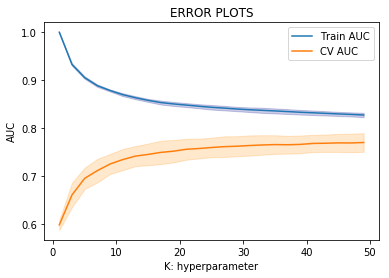

In [57]:
# To find out best k from graphical representations
train_auc= grid.cv_results_['mean_train_score']
train_auc_std= grid.cv_results_['std_train_score']
cv_auc = grid.cv_results_['mean_test_score'] 
cv_auc_std= grid.cv_results_['std_test_score']

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [58]:
#Finding the Optimal K
bow_opt_k= int(k_range[cv_auc.argmax()])
bow_opt_k

49

**Train the model**

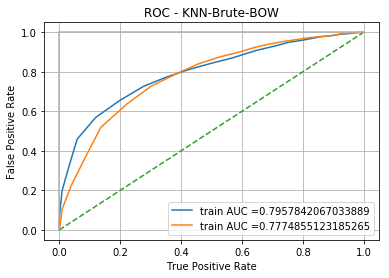

In [59]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


knn = KNeighborsClassifier(n_neighbors=bow_opt_k,algorithm='brute', n_jobs=-1)
knn.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, knn.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend(loc='best')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC - KNN-Brute-BOW')
plt.grid()
plt.show()




**conclusion**

In [60]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, knn.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, knn.predict(X_test_bow)))

Train confusion matrix
[[   71  1852]
 [   33 11157]]
Test confusion matrix
[[  47  921]
 [  22 4630]]


- **Apply Knn (kd_tree implementation)**

In [61]:
# Fuction to compute k value with kd_tree implementation# 
param_grid = dict(n_neighbors=list(range(1, 51,2)))
knn = KNeighborsClassifier(algorithm='kd_tree')
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='roc_auc', return_train_score=True,n_jobs=-1)
grid.fit(kdX_train,y_train)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

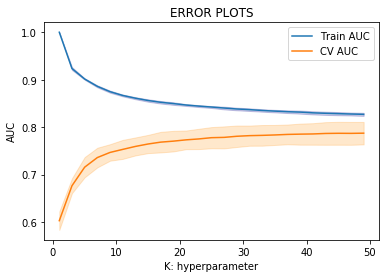

In [62]:
# To find out best k from graphical representations
train_auc= grid.cv_results_['mean_train_score']
train_auc_std= grid.cv_results_['std_train_score']
cv_auc = grid.cv_results_['mean_test_score'] 
cv_auc_std= grid.cv_results_['std_test_score']

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [63]:
#Finding the Optimal K
bow_opt_k = int(k_range[cv_auc.argmax()])
bow_opt_k

49

**Train the model**

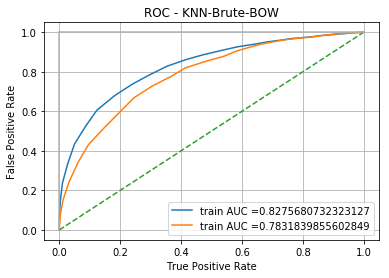

In [64]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

kd_knn = KNeighborsClassifier(n_neighbors=bow_opt_k,algorithm='kd_tree', n_jobs=-1)
kd_knn.fit(kdX_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, kd_knn.predict_proba(kdX_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, kd_knn.predict_proba(kdX_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend(loc='best')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC - KNN-Brute-BOW')
plt.grid()
plt.show()


**conclusion**

In [65]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, kd_knn.predict(kdX_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, kd_knn.predict(kdX_test)))

Train confusion matrix
[[   67  1856]
 [   42 11148]]
Test confusion matrix
[[  97  871]
 [  47 4605]]


# **Appling KNN with TFIDF**

In [66]:
# finding tfidf
tf_idf = TfidfVectorizer(ngram_range=(1,2), min_df=10,analyzer= clean_text)
X_train_tfidf= tf_idf.fit_transform(X_train)
print(X_train_tfidf.get_shape())
type(X_train_tfidf)

(13113, 3975)


scipy.sparse.csr.csr_matrix

In [67]:
# Test Vectorizor
X_test_tfidf= tf_idf.transform(X_test)
print(type(X_test_tfidf))
print(X_test_tfidf.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(5620, 3975)


In [68]:
# finding tfidf
kdtfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500, analyzer= clean_text)
kdX_train_tfidf= kdtfidf_vect.fit_transform(X_train)
print(type(kdX_train_tfidf))
print("the number of unique words ", kdX_train_tfidf.get_shape()[1])
print("the shape of out text BOW vectorizer ",kdX_train_tfidf.get_shape())

<class 'scipy.sparse.csr.csr_matrix'>
the number of unique words  500
the shape of out text BOW vectorizer  (13113, 500)


In [69]:
# Test Vectorizor
kd_test_tfidf= kdtfidf_vect.transform(X_test)
print(type(kd_test_tfidf))
print(kd_test_tfidf.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(5620, 500)


- **Apply Knn (brute_tree implementation)**

In [70]:
k_range = list(range(1,51,2))
# Fuction to compute k value with brute force algorithm # 
param_grid = dict(n_neighbors=list(range(1,51,2)))
knn = KNeighborsClassifier(algorithm='brute')
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='roc_auc', return_train_score=True,n_jobs=-1)
grid.fit(X_train_tfidf,y_train)



GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

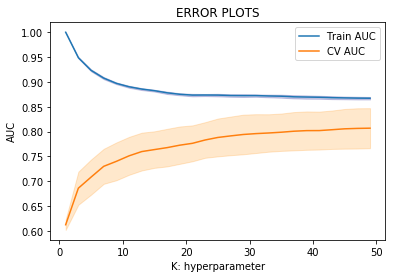

In [71]:
# To find out best k from graphical representations
train_auc= grid.cv_results_['mean_train_score']
train_auc_std= grid.cv_results_['std_train_score']
cv_auc = grid.cv_results_['mean_test_score'] 
cv_auc_std= grid.cv_results_['std_test_score']

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [72]:
#Finding the Optimal K
tfidf_opt_k = int(k_range[cv_auc.argmax()])
tfidf_opt_k

49

**Train the model**

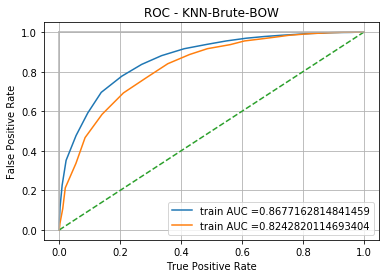

In [73]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


knn = KNeighborsClassifier(n_neighbors=tfidf_opt_k,algorithm='brute', n_jobs=-1)
knn.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, knn.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend(loc='best')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC - KNN-Brute-BOW')
plt.grid()
plt.show()


In [74]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train,knn.predict(X_train_tfidf)))
print('*'*50)
print("Test confusion matrix")
print(confusion_matrix(y_test,knn.predict(X_test_tfidf)))

Train confusion matrix
[[   91  1832]
 [   10 11180]]
**************************************************
Test confusion matrix
[[  44  924]
 [   0 4652]]


- **Apply Knn (kd_tree implementation)**

In [75]:
# Fuction to compute k value with kd_tree implementation# 
param_grid = dict(n_neighbors=list(range(1, 51,2)))
knn = KNeighborsClassifier(algorithm='kd_tree')
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='roc_auc', return_train_score=True,n_jobs=-1)
grid.fit(kdX_train_tfidf,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

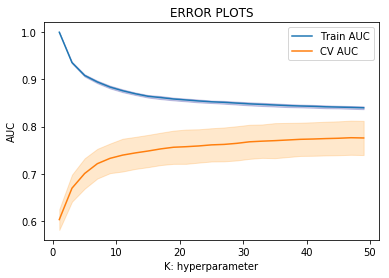

In [76]:
# To find out best k from graphical representations
train_auc= grid.cv_results_['mean_train_score']
train_auc_std= grid.cv_results_['std_train_score']
cv_auc = grid.cv_results_['mean_test_score'] 
cv_auc_std= grid.cv_results_['std_test_score']

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [77]:
#Finding the Optimal K
tfidf_opt_k = int(k_range[cv_auc.argmax()])
tfidf_opt_k

47

- **Train the model**

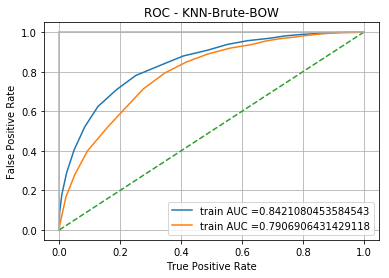

In [78]:

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

kd_knn = KNeighborsClassifier(n_neighbors=tfidf_opt_k,algorithm='kd_tree', n_jobs=-1)
kd_knn.fit(kdX_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, kd_knn.predict_proba(kdX_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, kd_knn.predict_proba(kd_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend(loc='best')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC - KNN-Brute-BOW')
plt.grid()
plt.show()


In [79]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, kd_knn.predict(kdX_train_tfidf)))
print('*'*50)
print("Test confusion matrix")
print(confusion_matrix(y_test, kd_knn.predict(kd_test_tfidf)))

Train confusion matrix
[[   83  1840]
 [    8 11182]]
**************************************************
Test confusion matrix
[[  38  930]
 [   2 4650]]


# Working with word2vec

In [0]:
# Train your own Word2Vec model using your own text corpus
T_list=X_train.values.tolist()
t_list=X_test.values.tolist()

In [81]:
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(T_list,min_count=5,size=50, workers=4)
w2v_model

In [82]:
print(w2v_model.wv.most_similar('like'))

[('weird', 0.8159828782081604), ('real', 0.8141513466835022), ('awful', 0.781792163848877), ('strange', 0.7732948064804077), ('unpalatable', 0.7711333632469177), ('sort', 0.7696452736854553), ('liked', 0.76763916015625), ('bland', 0.7664194107055664), ('grainy', 0.7649790644645691), ('nasty', 0.7637130618095398)]


In [83]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  6338
sample words  ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumb', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'sticker', 'removed', 'easily', 'daughter', 'designed', 'sign', 'printed', 'reverse', 'beautifully', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'surface', 'like', 'tv', 'screen', 'computer', 'chatchi', 'favorite', 'afternoon', 'treat', 'became']


In [84]:
# average Word2Vec for train
# compute average word2vec for each review.
train_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(T_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
print(len(train_vectors))

X_train_w2v= train_vectors

100%|██████████| 13113/13113 [00:21<00:00, 607.34it/s]

13113


In [85]:
# average Word2Vec for test
# compute average word2vec for each review.
test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(t_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
print(len(test_vectors))

X_test_w2v= test_vectors

100%|██████████| 5620/5620 [00:08<00:00, 636.13it/s]

5620


- **Apply Knn(brute force version)**

In [86]:
# knn based on brute force

k_range = list(range(1,51,2))
# Fuction to compute k value with brute force algorithm # 
param_grid = dict(n_neighbors=list(range(1,51,2)))
knn = KNeighborsClassifier(algorithm='brute')
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='roc_auc', return_train_score=True,n_jobs=-1)
grid.fit(X_train_w2v,y_train)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

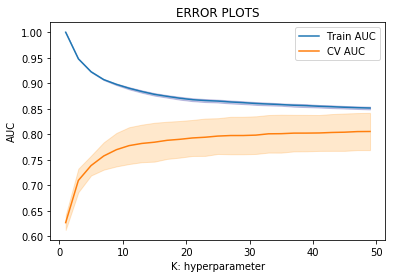

In [87]:
# To find out best k from graphical representations
train_auc = grid.cv_results_['mean_train_score']
train_auc_std = grid.cv_results_['std_train_score']
cv_auc = grid.cv_results_['mean_test_score'] 
cv_auc_std= grid.cv_results_['std_test_score']

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [88]:
#Finding the Optimal K
w2v_opt_k = int(k_range[cv_auc.argmax()])
w2v_opt_k

49

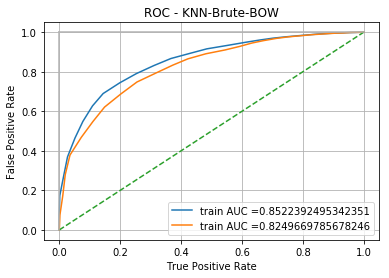

In [89]:

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

w2vmodel= KNeighborsClassifier(n_neighbors=w2v_opt_k,algorithm='brute', n_jobs=-1)
w2vmodel.fit(X_train_w2v, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, w2vmodel.predict_proba(X_train_w2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,    w2vmodel.predict_proba(X_test_w2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend(loc='best')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC - KNN-Brute-BOW')
plt.grid()
plt.show()

In [90]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, w2vmodel.predict(X_train_w2v)))
print("Test confusion matrix")
print(confusion_matrix(y_test, w2vmodel.predict(X_test_w2v)))

Train confusion matrix
[[  155  1768]
 [   41 11149]]
Test confusion matrix
[[  65  903]
 [  17 4635]]


- **Apply Knn (kd_tree implementation)**

In [91]:
# Fuction to compute k value with kd_tree implementation# 
param_grid = dict(n_neighbors=list(range(1, 51,2)))
knn = KNeighborsClassifier(algorithm='kd_tree')
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='roc_auc', return_train_score=True,n_jobs=-1)
grid.fit(X_train_w2v,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

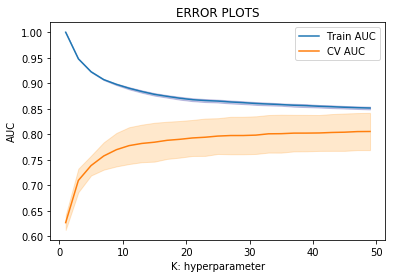

In [92]:
# To find out best k from graphical representations
train_auc = grid.cv_results_['mean_train_score']
train_auc_std = grid.cv_results_['std_train_score']
cv_auc = grid.cv_results_['mean_test_score'] 
cv_auc_std= grid.cv_results_['std_test_score']

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [93]:
#Finding the Optimal K
w2v_opt_k = int(k_range[cv_auc.argmax()])
w2v_opt_k


49

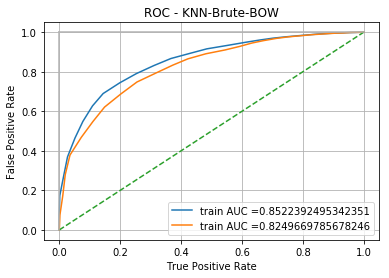

In [94]:

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

w2vmodel= KNeighborsClassifier(n_neighbors=w2v_opt_k,algorithm='kd_tree', n_jobs=-1)
w2vmodel.fit(X_train_w2v, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, w2vmodel.predict_proba(X_train_w2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,    w2vmodel.predict_proba(X_test_w2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend(loc='best')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC - KNN-Brute-BOW')
plt.grid()
plt.show()

In [95]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, w2vmodel.predict(X_train_w2v)))
print("Test confusion matrix")
print(confusion_matrix(y_test, w2vmodel.predict(X_test_w2v)))

Train confusion matrix
[[  155  1768]
 [   41 11149]]
Test confusion matrix
[[  65  903]
 [  17 4635]]


# Appling KNN with Tf-Idf weighted **Word2Vec**

In [0]:
tfidf_feat = tf_idf.get_feature_names() # tfidf words/col-names

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in T_list: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_train_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
tfidfw2v_train = np.nan_to_num(tfidf_sent_vectors_train)

In [0]:
# tfidf words/col-names

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in t_list: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_test_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
tfidfw2v_test = np.nan_to_num(tfidf_sent_vectors_test)

In [98]:
# knn based on brute force

k_range = list(range(1,51,2))
# Fuction to compute k value with brute force algorithm # 
param_grid = dict(n_neighbors=list(range(1,51,2)))
knn = KNeighborsClassifier(algorithm='brute')
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='roc_auc', return_train_score=True,n_jobs=-1)
grid.fit(tfidfw2v_train,y_train)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

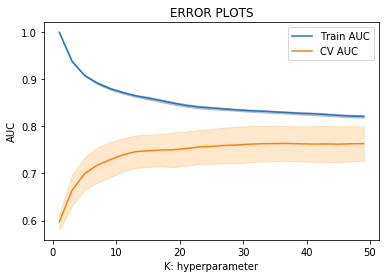

In [99]:
# To find out best k from graphical representations
train_auc = grid.cv_results_['mean_train_score']
train_auc_std = grid.cv_results_['std_train_score']
cv_auc = grid.cv_results_['mean_test_score'] 
cv_auc_std= grid.cv_results_['std_test_score']

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [100]:
#Finding the Optimal K
tfidfw2v_opt_k = int(k_range[cv_auc.argmax()])
print(tfidfw2v_opt_k)

37


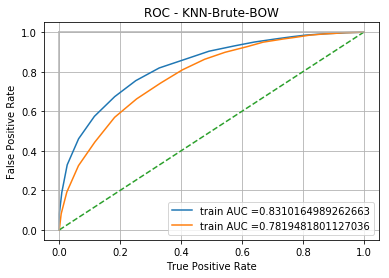

In [101]:

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

tfidfw2vmodel= KNeighborsClassifier(n_neighbors=tfidfw2v_opt_k,algorithm='brute', n_jobs=-1)
tfidfw2vmodel.fit(tfidfw2v_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, tfidfw2vmodel.predict_proba(tfidfw2v_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,    tfidfw2vmodel.predict_proba(tfidfw2v_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend(loc='best')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC - KNN-Brute-BOW')
plt.grid()
plt.show()

In [102]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, tfidfw2vmodel.predict(tfidfw2v_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, tfidfw2vmodel.predict(tfidfw2v_test)))

Train confusion matrix
[[  109  1814]
 [   27 11163]]
Test confusion matrix
[[  58  910]
 [   9 4643]]


- **Apply Knn (kd_tree implementation)**

In [103]:
# Fuction to compute k value with kd_tree implementation# 
param_grid = dict(n_neighbors=list(range(1, 51,2)))
knn = KNeighborsClassifier(algorithm='kd_tree')
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='roc_auc', return_train_score=True,n_jobs=-1)
grid.fit(tfidfw2v_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

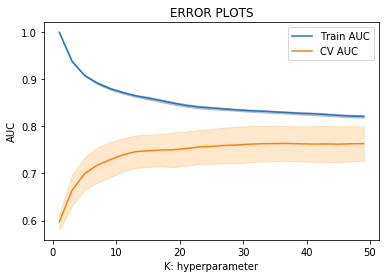

In [104]:
# To find out best k from graphical representations
train_auc = grid.cv_results_['mean_train_score']
train_auc_std = grid.cv_results_['std_train_score']
cv_auc = grid.cv_results_['mean_test_score'] 
cv_auc_std= grid.cv_results_['std_test_score']

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [105]:
#Finding the Optimal K
tfidfw2v_opt_k = int(k_range[cv_auc.argmax()])
print(tfidfw2v_opt_k)

37


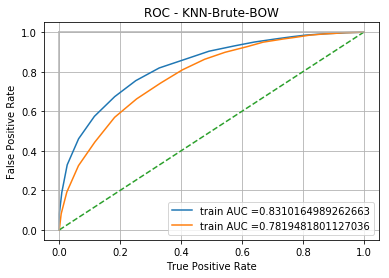

In [106]:

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

tfidfw2vmodel= KNeighborsClassifier(n_neighbors=tfidfw2v_opt_k,algorithm='kd_tree', n_jobs=-1)
tfidfw2vmodel.fit(tfidfw2v_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, tfidfw2vmodel.predict_proba(tfidfw2v_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,    tfidfw2vmodel.predict_proba(tfidfw2v_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend(loc='best')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC - KNN-Brute-BOW')
plt.grid()
plt.show()

In [107]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, tfidfw2vmodel.predict(tfidfw2v_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, tfidfw2vmodel.predict(tfidfw2v_test)))

Train confusion matrix
[[  109  1814]
 [   27 11163]]
Test confusion matrix
[[  58  910]
 [   9 4643]]


In [109]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperameter", "train_AUC", 'test_AUC']
x.add_row(["BOW","Brute",49,0.7957,0.7774])
x.add_row(["TFIDF","Brute",49,0.86771,0.82428])
x.add_row(["AwgW2V","Brute",49,0.8522,0.8249])
x.add_row(["TFIDF W2V","Brute",37,0.8310,0.7819])
x.add_row(["BOW","k_d tree",49,0.8275,0.7831])
x.add_row(["TFIDF","k_d tree",47,0.84210,0.7906906])
x.add_row(["AwgW2V","k_d tree",49,0.8522,0.82135])
x.add_row(["TFIDF W2V","k_d tree",37,0.8310,0.7819])
print(x)

+------------+----------+-------------+-----------+-----------+
| Vectorizer |  Model   | Hyperameter | train_AUC |  test_AUC |
+------------+----------+-------------+-----------+-----------+
|    BOW     |  Brute   |      49     |   0.7957  |   0.7774  |
|   TFIDF    |  Brute   |      49     |  0.86771  |  0.82428  |
|   AwgW2V   |  Brute   |      49     |   0.8522  |   0.8249  |
| TFIDF W2V  |  Brute   |      37     |   0.831   |   0.7819  |
|    BOW     | k_d tree |      49     |   0.8275  |   0.7831  |
|   TFIDF    | k_d tree |      47     |   0.8421  | 0.7906906 |
|   AwgW2V   | k_d tree |      49     |   0.8522  |  0.82135  |
| TFIDF W2V  | k_d tree |      37     |   0.831   |   0.7819  |
+------------+----------+-------------+-----------+-----------+


- **As in "knn with tfidf and AwgW2V " when k = 49 the accuracy is quite good than other models. In this model, train_error and test_error is low.**
- **We need to balance between both i.e. reduce training error and reduce error between training and testing error.**